# Mean Variance Investment Strategy
## Use Index of representative asset classes
#### Developed-Emerging Equity, Real estate, Commodity, Treasury, Corporate Bond are included
#### This note use Developed Equity, Emerging Equity, LongTerm Treasury, Real Estate to calculate Mean-Varaiance Optimized portfolio
#### Result is driven from 2010 to 2021 market data

In [35]:
import warnings
warnings.filterwarnings('ignore')

In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
plt.rcParams["figure.figsize"] = (12, 8) # (width, height)

In [37]:
print("current directory is : ", os.getcwd())
os.chdir('/mnt/e/workspace/asset_allocation_strategy/')
print("changed directory is : ", os.getcwd())

current directory is :  /mnt/e/workspace/asset_allocation_strategy
changed directory is :  /mnt/e/workspace/asset_allocation_strategy


In [38]:
from backtest.backtest_engine import BacktestEngine
from backtest.target_generator import TargetGenerator

In [39]:
from benchmark_strategy.equal_weight import EqualWeightGenerator
from benchmark_strategy._60_40_allocation import _60_40_allocation
from benchmark_strategy._50_50_allocation import _50_50_allocation

[__init__] is executed in 5.82 seconds


In [40]:
import quantstats
from scipy.optimize import minimize

In [57]:
start_date='2006-01-01'
end_date='2022-06-01'
cost=0.001

In [41]:
class MeanVarianceWeightGenerator(TargetGenerator):
    def __init__(self, cache):
        super().__init__(cache)

    def compute_target(self, universe_list):


        """
        Inputs
            universe_list(list) : list of ETFs that weights should be computed
        Outputs
            target_weight(dict)
        """
        # print(self.bdates[1], self.bdates[-1])
        # print(engine.date)

        date = engine.date

        target_weight = {}
        target_weight = self.compute_factor(date=date,  tickers=universe_list)

        return target_weight


    def compute_factor(self, date, tickers):
        """
        Inputs
            ticker(str) : name of ETF
            ftype(str) : name of factor
        Outputs
            float
        """
        date_1_month_lag = date - relativedelta(month=1)

        return_df = pd.DataFrame()
        for ticker in tickers:
            asset_series = self.cache['index'][ticker]['closeadj']
            asset_series.rename(ticker, inplace=True)
            return_df[ticker] = asset_series
        
        return_df = return_df.loc[date_1_month_lag : date]
        return_df =  return_df.pct_change(1)
        return_df = return_df.fillna(1)
        
        self.return_df_dd = return_df

        def get_ret_vol_sharpe(weight):
            weight = np.array(weight)
            ret = np.sum(return_df.mean() * weight) * 252
            vol = np.sqrt(np.dot(weight.T, np.dot(return_df.cov()*252, weight)))
            # set risk free rate as 1.5%
            sharpe = (ret-0.015)/vol
            return {'return':ret, 'volatility':vol, 'sharpe':sharpe}

        def neg_sharpe(weight):
            # to use convex optimization, change sign to minus to solve minimization problem.
            return get_ret_vol_sharpe(weight)['sharpe'] * -1

        def min_vol(weight):
            # to use convex optimization, finding minimum volatility doesn't require sign change
            return get_ret_vol_sharpe(weight)['volatility']

        # constraint : sum of weight should be less than equal to 1
        def check_sum(weight):
            #return 0 if sum of the weights is 1
            return np.sum(weight)-1

        ######################## starts here #######################-
        cons = (
        {'type':'eq',
        'fun':check_sum}
        )

        
        bounds = []
        initial = []
        for i in range(len(tickers)):
            bounds.append((0,1))
            initial.append(1/len(tickers))
        bounds = tuple(bounds)

        optimizer = minimize(neg_sharpe, initial, method='SLSQP', bounds = bounds, constraints = cons)
        
        weight = []
        for i in range(len(tickers)):
            weight.append(optimizer.x[i])
        
        weights = {}
        i = 0
        for ticker in tickers:
            weights[ticker] = weight[i]
            i = i+1
                
        return weights 

In [42]:
custom_universe = ['SPY','EFA','EEM','TLT','IEF','SHY','LQD']
engine = BacktestEngine(yfinance_list=custom_universe, fred_list=[], market_fred_list=[])
mvg = MeanVarianceWeightGenerator(engine.cache)
engine.run_backtest(target_generator=mvg, sdate=start_date, edate=end_date, transaction_cost=cost)

[__init__] is executed in 7.60 seconds
Backtest period: 2006-01-03 00:00:00 -- 2022-06-01 00:00:00
=== date:2022-06-01 00:00:00 / total_asset:2.744 / time elapsed:16.6 ===
[run_backtest] is executed in 16.81 seconds


In [43]:
myasset = engine.asset_df.sum(axis=1)
myasset

2006-01-03    0.999000
2006-01-04    1.008057
2006-01-05    1.013186
2006-01-06    1.034355
2006-01-09    1.044503
                ...   
2022-05-25    2.752451
2022-05-26    2.753111
2022-05-27    2.753771
2022-05-31    2.749482
2022-06-01    2.744365
Length: 4132, dtype: float64

In [44]:
custom_universe = ['SPY','EFA','EEM','TLT','IEF','SHY','LQD']
bm_engine = BacktestEngine(yfinance_list=custom_universe)
equal_weight = EqualWeightGenerator(bm_engine.cache)
bm_engine.run_backtest(target_generator=equal_weight, sdate=start_date, edate=end_date, transaction_cost=cost)
benchmark = bm_engine.asset_df.sum(axis=1)
benchmark

[__init__] is executed in 7.29 seconds
Backtest period: 2006-01-03 00:00:00 -- 2022-06-01 00:00:00
=== date:2022-06-01 00:00:00 / total_asset:2.317 / time elapsed:4.7 ===
[run_backtest] is executed in 4.81 seconds


2006-01-03    0.999000
2006-01-04    1.002894
2006-01-05    1.002854
2006-01-06    1.008360
2006-01-09    1.010457
                ...   
2022-05-25    2.310684
2022-05-26    2.324136
2022-05-27    2.342991
2022-05-31    2.330066
2022-06-01    2.316651
Length: 4132, dtype: float64

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2006-01-03  2006-01-03
End Period                 2022-06-01  2022-06-01
Risk-Free Rate             0.0%        0.0%
Time in Market             99.0%       100.0%

Cumulative Return          174.71%     131.9%
CAGR﹪                     6.35%       5.26%

Sharpe                     0.43        0.6
Smart Sharpe               0.41        0.57
Sortino                    0.62        0.86
Smart Sortino              0.58        0.81
Sortino/√2                 0.44        0.61
Smart Sortino/√2           0.41        0.57
Omega                      1.08        1.08

Max Drawdown               -36.91%     -26.37%
Longest DD Days            1087        831
Volatility (ann.)          18.1%       9.21%
R^2                        0.19        0.19
Calmar                     0.17        0.2
Skew                       0.03        -0.01
Kurtosis                   5.12        13.3

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-11-01,2009-03-10,2009-10-12,711,-36.906438,-36.853718
2,2015-04-29,2016-01-20,2017-10-13,898,-26.126724,-25.180949
3,2022-01-04,2022-04-29,2022-06-01,148,-21.029263,-20.633352
4,2011-12-20,2012-08-16,2013-09-18,638,-19.989952,-18.151773
5,2018-01-29,2020-03-18,2021-01-20,1087,-18.660848,-17.244768


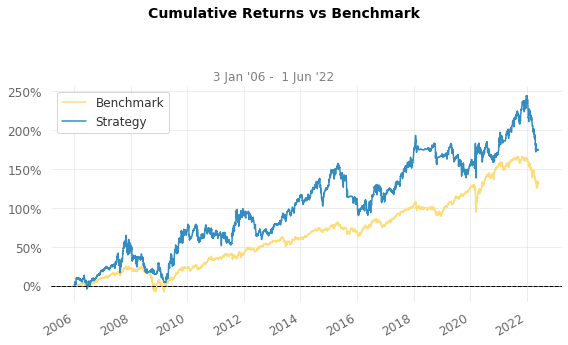

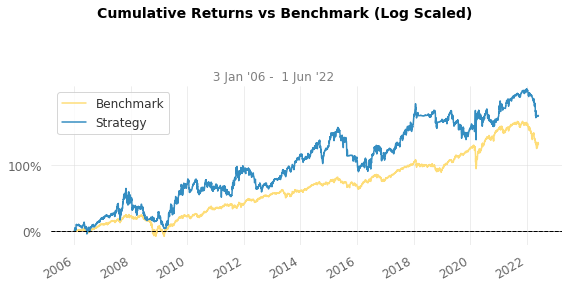

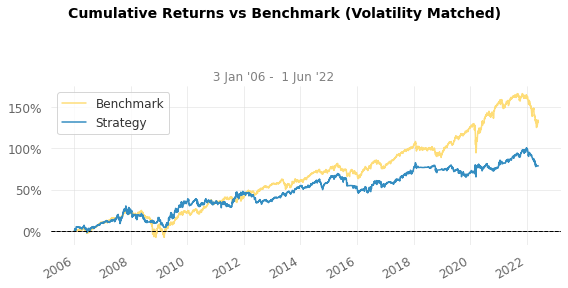

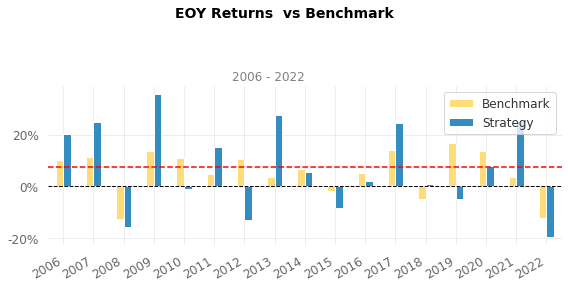

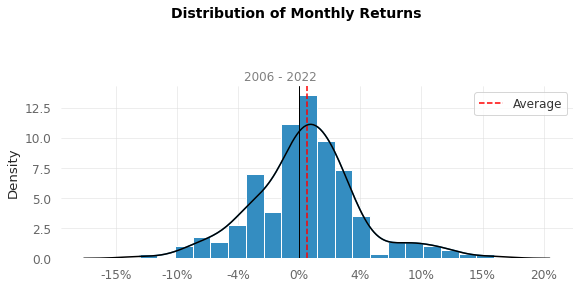

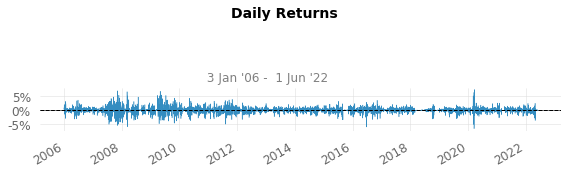

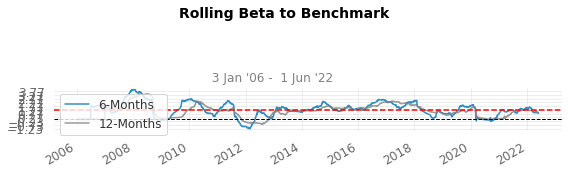

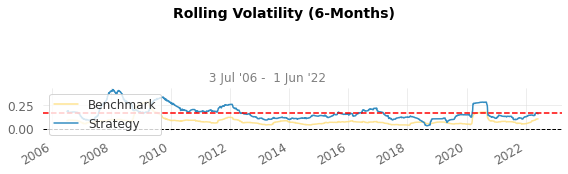

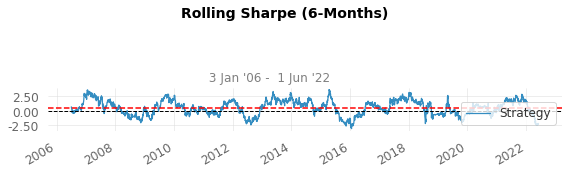

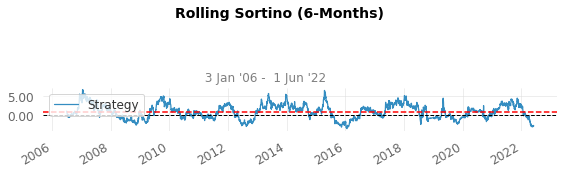

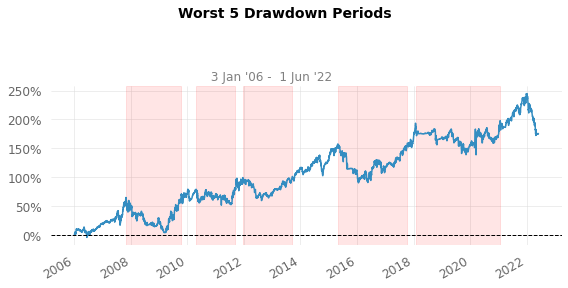

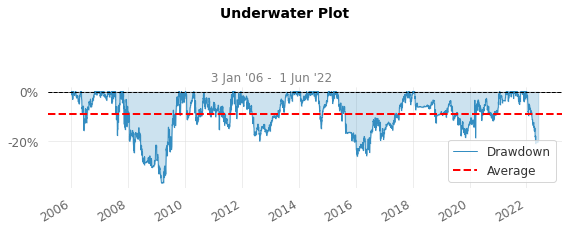

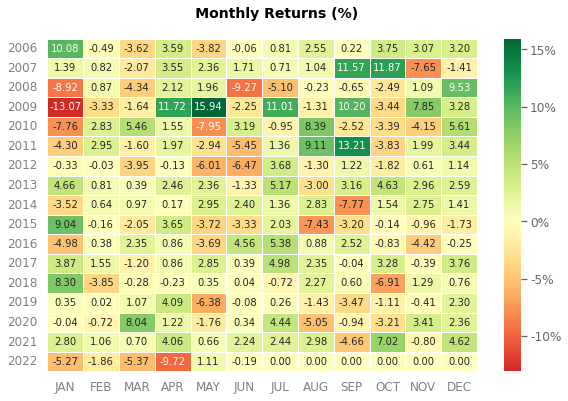

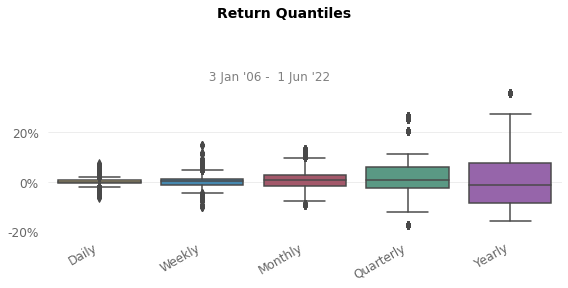

In [46]:
quantstats.reports.full(returns=myasset, benchmark=benchmark)

In [61]:
custom_universe = ['SPY','EFA','EEM','TLT','IEF','SHY','LQD']
df = pd.DataFrame()

for ticker in custom_universe:
    _df = engine.cache['index'][ticker]['closeadj'].loc[start_date:end_date]
    df =  pd.concat([df,_df],axis=1)

return_df=df/df.shift(1)
return_df=return_df.fillna(1)
return_df

,SPY,EFA,EEM,TLT,IEF,SHY,LQD
2006-01-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2006-01-04,1.004735,1.008303,1.009066,1.002397,1.001788,1.000995,1.000000
2006-01-05,1.000629,0.994994,1.005088,0.998805,1.000238,0.999130,1.000831
2006-01-06,1.008322,1.013470,1.020893,0.998150,0.998692,1.000249,0.998432
2006-01-09,1.002569,1.000480,1.009811,1.000654,1.000476,1.000124,1.000185
...,...,...,...,...,...,...,...
2022-05-25,1.008835,1.000291,1.004910,1.003954,1.002017,1.000720,1.010309
2022-05-26,1.019981,1.011042,1.015636,0.995475,0.999521,1.000240,1.000262
2022-05-27,1.024549,1.012071,1.011547,1.002441,1.001439,1.000240,1.005231
2022-05-31,0.994389,0.994037,1.014031,0.978838,0.989560,0.998443,0.992627


In [69]:
num_ports = 10000
all_weights = np.zeros((num_ports, len(return_df.columns)))
ret, vol, sharpe = np.zeros(num_ports), np.zeros(num_ports), np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(len(return_df.columns)))
    weights = weights/np.sum(weights)

    # Save weights
    all_weights[x,:] = weights

    # Expected Annual return
    ret[x] = np.sum(((return_df.mean()-1) * weights * 252))
    # Expected Annual volatility
    vol[x] = np.sqrt(np.dot(weights.T, np.dot(return_df.cov()*252, weights)))
    # Sharpe Ratio assuming risk free rate is 1.5%
    sharpe[x] = (ret[x]-0.015)/vol[x]

In [72]:
print("Max return portfolio")
print("#{} with annual return {}% and sharpe {} ".format(ret.argmax(), round(100*ret.max(),2), round(sharpe[ret.argmax()],2)))
print("developed market stock:{}, emerging market stock:{}, global bond:{}, real_estate {}".format(all_weights[ret.argmax(),0], all_weights[ret.argmax(),1], all_weights[ret.argmax(),2], all_weights[ret.argmax(),3]))
print("########################################################################################################")

print("Max risk adjusted return portfolio")
print("#{} with annual return {}% and sharpe {} ".format(sharpe.argmax(), round(100*ret[sharpe.argmax()],2), round(sharpe.max(),2)))
print("developed market stock:{}, emerging market stock:{}, global bond:{}, real_estate {}".format(all_weights[sharpe.argmax(),0], all_weights[sharpe.argmax(),1], all_weights[sharpe.argmax(),2], all_weights[sharpe.argmax(),3]))
print("########################################################################################################")

print("Min risk portfolio")
print("#{} with annual return {}% and sharpe {} ".format(vol.argmin(), round(100*ret[vol.argmin()],2), round(sharpe[vol.argmin()],2)))
print("developed market stock:{}, emerging market stock:{}, global bond:{}, real_estate {}".format(all_weights[vol.argmin(),0], all_weights[vol.argmin(),1], all_weights[vol.argmin(),2], all_weights[vol.argmin(),3]))
print("########################################################################################################")


Max return portfolio
#7671 with annual return 8.83% and sharpe 0.4 
developed market stock:0.5535036685332764, emerging market stock:0.12006649440771675, global bond:0.18768454112215077, real_estate 0.01974930122168007
########################################################################################################
Max risk adjusted return portfolio
#1848 with annual return 4.94% and sharpe 0.71 
developed market stock:0.199942999792533, emerging market stock:0.0029726489822963307, global bond:0.026724976818303794, real_estate 0.09037566761741389
########################################################################################################
Min risk portfolio
#8783 with annual return 3.41% and sharpe 0.54 
developed market stock:0.03796631312742241, emerging market stock:0.10610578554816603, global bond:0.01000773438715132, real_estate 0.05185020639774016
########################################################################################################


In [104]:
mv_portfolio = pd.DataFrame(index=['portfolio_#','return','volatility','sharpe'], columns=['max_return', 'max_sharpe', 'min_volatility'])

mv_portfolio.loc['portfolio_#', 'max_return'] = ret.argmax()
mv_portfolio.loc['portfolio_#', 'max_sharpe'] = sharpe.argmax()
mv_portfolio.loc['portfolio_#', 'min_volatility'] = vol.argmax()

mv_portfolio.loc['return', 'max_return'] = round(100*ret.max(),2)
mv_portfolio.loc['return', 'max_sharpe'] = round(100*ret[sharpe.argmax()],2)
mv_portfolio.loc['return', 'min_volatility'] = round(100*ret[vol.argmin()],2)

mv_portfolio.loc['volatility', 'max_return'] = round(100*vol[ret.argmax()],2)
mv_portfolio.loc['volatility', 'max_sharpe'] = round(100*vol[sharpe.argmax()],2)
mv_portfolio.loc['volatility', 'min_volatility'] =  round(100*vol.min(),2)

mv_portfolio.loc['sharpe', 'max_return'] = round(sharpe[ret.argmax()],2)
mv_portfolio.loc['sharpe', 'max_sharpe'] = round(sharpe.max(),2)
mv_portfolio.loc['sharpe', 'min_volatility'] = round(sharpe[ret.argmax()],2)

mv_result = pd.DataFrame(index=return_df.columns, columns=['max_return', 'max_sharpe', 'min_volatility'])

for i in range(len(mv_result.index)):
    mv_result['max_return'].iloc[i] = round(all_weights[ret.argmax(),i],2)
for i in range(len(mv_result.index)):
    mv_result['max_sharpe'].iloc[i] = round(all_weights[sharpe.argmax(),i],2)
for i in range(len(mv_result.index)):
    mv_result['min_volatility'].iloc[i] = round(all_weights[vol.argmin(),i],2)


In [105]:
mv_result

,max_return,max_sharpe,min_volatility
SPY,0.55,0.2,0.04
EFA,0.12,0.0,0.11
EEM,0.19,0.03,0.01
TLT,0.02,0.09,0.05
IEF,0.01,0.31,0.25
SHY,0.08,0.32,0.52
LQD,0.03,0.05,0.02


In [106]:
mv_portfolio

,max_return,max_sharpe,min_volatility
portfolio_#,7671,1848,3658
return,8.83,4.94,3.41
volatility,18.38,4.83,3.54
sharpe,0.4,0.71,0.4


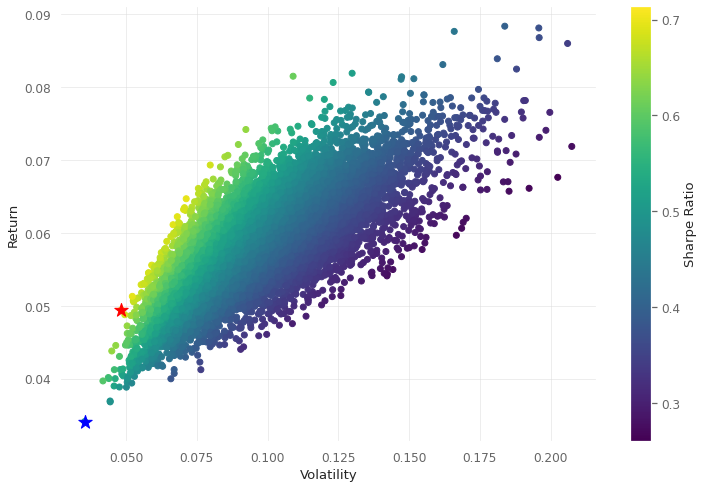

In [107]:
plt.figure(figsize=(12,8))
plt.scatter(vol, ret, c=sharpe, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(vol[sharpe.argmax()], ret[sharpe.argmax()], c='red', s=200, marker="*") # red star means max sharpe return
plt.scatter(vol[vol.argmin()], ret[vol.argmin()], c='blue', s=200, marker="*") # blue star means min volatility
plt.show()

In [75]:
def get_ret_vol_sharpe(weight):
    weight = np.array(weight)
    ret = np.sum(return_df.mean() * weight) * 252
    vol = np.sqrt(np.dot(weight.T, np.dot(return_df.cov()*252, weight)))
    # set risk free rate as 1.5%
    sharpe = (ret-0.015)/vol
    return {'return':ret, 'volatility':vol, 'sharpe':sharpe}

def neg_sharpe(weight):
    # to use convex optimization, change sign to minus to solve minimization problem.
    return get_ret_vol_sharpe(weight)['sharpe'] * -1

def min_vol(weight):
    # to use convex optimization, finding minimum volatility doesn't require sign change
    return get_ret_vol_sharpe(weight)['volatility']

# constraint : sum of weight should be less than equal to 1
def check_sum(weight):
    #return 0 if sum of the weights is 1
    return np.sum(weight)-1

In [112]:
#### format of bounds, initial are just like below
# bounds = ((0,1),(0,1),(0,1),(0,1))
# initial = [0.25, 0.25, 0.25, 0.25] # 1/N weight for default

bounds=((0,1),)
for i in range(len(return_df.columns)-1):
    bounds = bounds + ((0,1),)
eq_weight = 1/len(return_df.columns) 
initial = [eq_weight for eq_weight in range(len(return_df.columns))]

In [110]:
cons = (
    {'type':'eq',
     'fun':check_sum}
)
optimizer = minimize(neg_sharpe, initial, method='SLSQP', bounds = bounds, constraints = cons)
print(optimizer)


     fun: -20591.182521216626
     jac: array([11301.13598633, 22557.51342773, 27539.97583008, 78614.50195312,
       44764.12792969,  -475.32324219, 33088.17236328])
 message: 'Positive directional derivative for linesearch'
    nfev: 53
     nit: 10
    njev: 6
  status: 8
 success: False
       x: array([2.03998455e-02, 2.29239273e-04, 6.20924775e-03, 5.42410386e-04,
       4.12440893e-05, 9.76446865e-01, 3.53793800e-04])


In [111]:
frontier_y = np.linspace(ret.min(), ret.max(), 200)
frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sharpe(w)['return'] - possible_return})

    result = minimize(min_vol, initial, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

In [114]:
plt.figure(figsize=(12,8))
plt.scatter(vol, ret, c=sharpe, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x,frontier_y, 'r--', linewidth=3)
plt.show()